### Load tools we need for calculations:

Note that the FFTLog frequency array need not to be changed when cosmology changes. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import Calculation as cln
import os

import Cosmology as Csm
import params as pa
defcos = Csm.MyCosmology()
sampling_cosmo = Csm.Sampling()
#sampling_cosmo = Csm.Sampling(pa.c, pa.zCMB, pa.zmax, pa.h, pa.omch2, pa.ombh2, pa.ns, pa.s8)

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb
Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb
Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


In [2]:
khmin = 1e-8
khmax = 52.0
Nmax = 200
bias = -0.5
nu_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, bias, 0, Nmax, khmin, khmax)[:, 1]

Here we pre-calculate the special functions for clustering, which is independent of cosmology. As long as Nmax and bias is the same we do not need to re-run the special functions.

In [3]:
func_real_list, func_imag_list = cln.special_func_generator(x_min = 1e-6, x_max = 1e5, N_sample = 1000, nu_n_array=nu_n_array)

New Import
Number of interpolation sampling points are: 1000
Modified arguments are in the interval of [ 1e-06 , 100000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 3.7214996536572773 min


### The following expansion coeffs contain the information of cosmology:

In [4]:
c_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, bias, 0, Nmax, khmin, khmax)[:, 0]

In [5]:
our_l = np.array([2+i for i in range(98)]+[100+10*i for i in range(41)])

#### Example for unequal time clustering case: $z_1=2.0, z_2=3.5$, $\sigma_z = 0.3$:

In [6]:
Cl235 = cln.full_calc_sampling(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, nu_n_array, func_real_list, func_imag_list)
Cl235_mod = cln.full_calc_sampling_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array, nu_n_array, func_real_list, func_imag_list)

Cl235_limber = np.array([cln.Cn_Limber(li, defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(3.5), 0.3/defcos.HH(3.5), 0.1, 7000) for li in our_l])
Cl235_limber_mod = np.array([cln.Cn_Limber(np.sqrt(li*(li+1)), defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(3.5), 0.3/defcos.HH(3.5), 0.1, 7000) for li in our_l])

Time for preparing mesh-grids is: 0.0790700912475586 s
Time for calculating each l is: 0.08227653126064823 s
Time for preparing mesh-grids is: 0.06807994842529297 s
Time for calculating each l is: 0.08211965526608254 s


### Example for CMB lensing:

note that we need to recalculate the special functions

### Full-sky:

In [6]:
l_camb = np.array([0+i for i in range(501)])
Dlpp = defcos.results.get_lens_potential_cls(lmax = 500)[:,0]
Clpp = np.array([ Dlpp[np.where(l_camb == li)[0]][0] for li in our_l])*(2*np.pi)/(our_l*(our_l+1))**2

### For the approximation without radial derivative, we do not need to re-evaluate the special functions, but use those for the clustering case instead.

In [13]:
Cl_CMBlensing_wo_rad = cln.full_calc_sampling_CMBlensing_wo_rad(our_l, 200, 200, 1100, c_n_array, nu_n_array, func_real_list, func_imag_list)

(402, 200) (402, 200)
Time for preparing mesh-grids is: 28.742763996124268 s
Time for calculating each l is: 1.1264816908527622 s


In [7]:
func_real_list_lensing, func_imag_list_lensing = cln.special_func_generator_CMBlensing(x_min = 1e-6, x_max = 1e5, N_sample = 1000, nu_n_array=nu_n_array)

Number of interpolation sampling points are: 1000
Modified arguments are in the interval of [ 1e-06 , 100000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 2.4273709853490195 min


In [8]:
Cl_CMBlensing = cln.full_calc_sampling_CMBlensing(our_l, 50, 50, 1100, c_n_array, nu_n_array, func_real_list_lensing, func_imag_list_lensing)
Cl_CMBlensing_mod = cln.full_calc_sampling_CMBlensing_mod(our_l, 50, 50, 1100, c_n_array, nu_n_array, func_real_list_lensing, func_imag_list_lensing)

Cl_CMBlensing_limber_recal = np.array([cln.Limber_CMBlensing(np.sqrt(li*(li+1)), 0.1, sampling_cosmo.default_cosmo.chi(1090)) for li in our_l])
Cl_CMBlensing_limber = np.array([cln.Limber_CMBlensing(li, 0.1, sampling_cosmo.default_cosmo.chi(1090)) for li in our_l])



(102, 50) (102, 50)
Time for preparing mesh-grids is: 0.8012051582336426 s
Time for calculating each l is: 0.060732467569035595 s
(102, 50) (102, 50)
Time for preparing mesh-grids is: 0.7464339733123779 s
Time for calculating each l is: 0.06038295450828058 s


### Example for RSD clustering:

In [12]:
import Calculation_RSD as cln_rsd
x_min = 1e-6
x_max = 1e5
N_sample = 1000

func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4 = \
    cln_rsd.special_func_rsd(x_min, x_max, N_sample, Nmax, c_n_array, nu_n_array)

Note: redshifts have been re-sorted (earliest first)
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201
Number of interpolation sampling points are: 1000
Modified arguments are in the interval of [ 1e-06 , 100000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 7.166241268316905 min
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


In [13]:
Cl235_RSD = cln_rsd.full_calc_sampling_RSD(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, cln_rsd.curl_Cl_RSD_mesh,c_n_array, nu_n_array,\
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)
Cl235_RSD_mod = cln_rsd.full_calc_sampling_RSD_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, cln_rsd.curl_Cl_RSD_mesh,c_n_array,nu_n_array, \
    func_real_list2, func_imag_list2, func_real_list3, func_imag_list3, func_real_list4, func_imag_list4)

Cl235_RSD_our = Cl235_RSD[:,0]
Cl235_RSD_our_mod = Cl235_RSD_mod[:,0]

z1 = 2.0
z2 = 3.5
sigma_z = 0.3
chi_avg1 = defcos.chi(z1)
chi_sigma1 = sigma_z / defcos.HH(z1)
chi_avg2 = defcos.chi(z2)
chi_sigma2 = sigma_z / defcos.HH(z2)
C235_limber_intpart_new = np.array([cln_rsd.CRSD_Limber(li, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, 5, 5000-5 ) for li in our_l])

Time for preparing mesh-grids is: 0.05676984786987305 s
Time for calculating each l is: 0.44696326393017666 s
Time for preparing mesh-grids is: 0.046460866928100586 s
Time for calculating each l is: 0.44115662574768066 s


# Plots:

In [7]:
from scipy.interpolate import interp1d
def plot_compare(Cl_full, Cl_limber, Cl_limber1, our_l, our_Cl, our_Cl_mod, ymin, ymax, xmin, xmax, rescale, title):


    #l_limber = np.load(path_Limber)[0,:]
    #Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True, constrained_layout= True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
   
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r',linewidth = 3 ,label=r'Flat-sky')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g',linewidth = 3 ,label=r'Flat-sky recal.')
    ax0.plot(our_l, np.abs(Cl_limber)*rescale, '--', color = 'b', linewidth = 3, label=r'Limber')
    ax0.plot(our_l, np.abs(Cl_limber1)*rescale, '--', color = 'c', linewidth = 3, label=r'Limber recal.')
    ax0.plot(our_l, np.abs(np.array(Cl_full))*rescale,'-.', color = 'k', linewidth = 3, label=r'Full-sky')
    
    ax0.set_title(title, fontsize=30)
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend(prop={'size':18}, frameon = True)
    ax0.set_ylabel(r'$C_{\ell}\ (\times 10^{%d})$'%np.log10(rescale), fontsize=30)
    #ax0.set_ylabel(r'$|C_{\ell}|\ (\times 10^{%d})$'%np.log10(rescale), fontsize=30)
    ax0.tick_params(labelsize=30)
    
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(our_l, (our_Cl/Cl_full-1)*100, color='r',linewidth = 3)
    ax1.plot(our_l, (Cl_limber/np.array(Cl_full)-1)*100,'--', color='b',linewidth = 3)
    ax1.plot(our_l, (Cl_limber1/np.array(Cl_full)-1)*100,'--', color='c',linewidth = 3)
    ax1.plot(our_l, (our_Cl_mod/Cl_full-1)*100, color='g',linewidth = 3)
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k',linewidth = 3)
    
    ax1.set_xscale('log')
    ax1.set_ylim(-5, 5)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=30)
    ax1.set_xlabel(r'$\ell$',fontsize=30)
    ax1.set_ylabel(r'Rel. err. [%]',fontsize=30)

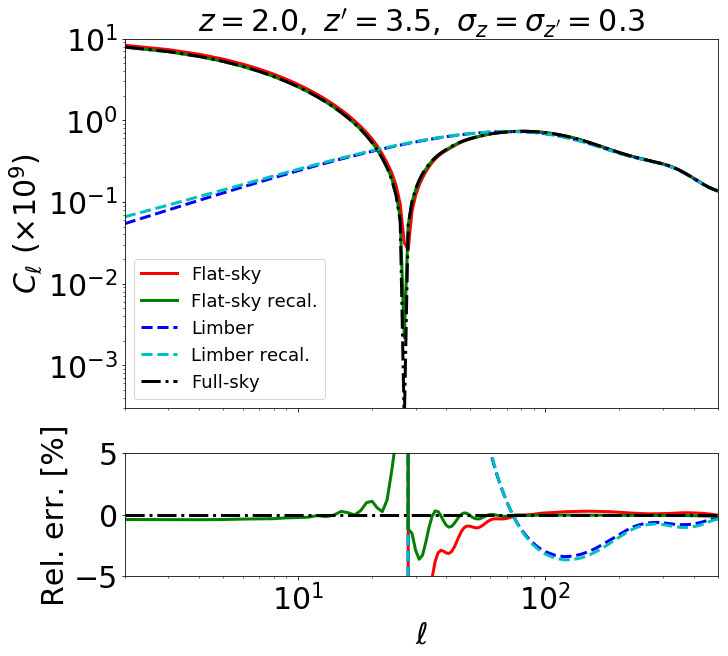

In [8]:
Cl235_full = np.loadtxt('./Full-sky/Cl_235_number.txt')[:,1]
plot_compare(Cl235_full,\
    Cl235_limber, Cl235_limber_mod, np.array(our_l), Cl235, Cl235_mod, 0.0003, 10, 2, 500, 1e9, r"$z=2.0,\ z'=3.5,\ \sigma_z=\sigma_{z'}=0.3$")

Text(0, 0.5, '$\\rm Rel. err.\\,[\\%]$')

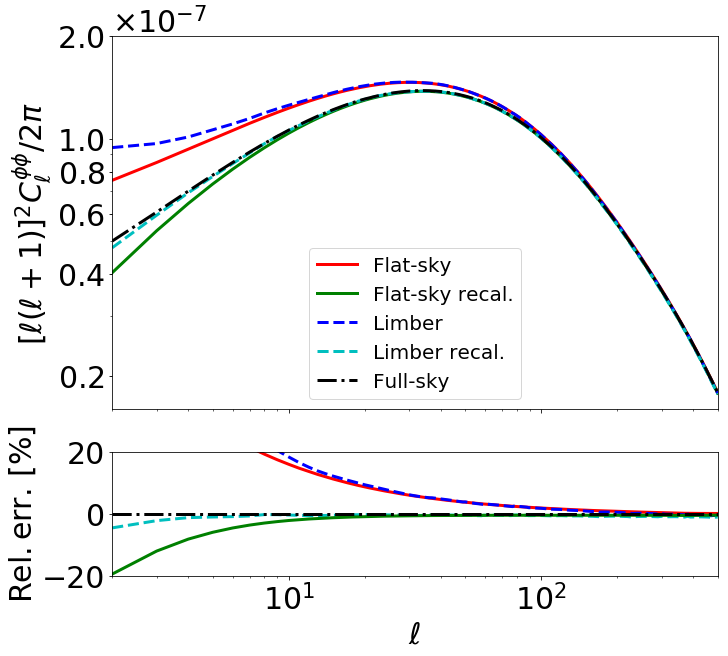

In [11]:
#l_full = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,0]
import matplotlib.ticker as ticker
plt.rc('font',size=30)
fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True, constrained_layout= True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.01})
ax0,ax1 = axes[0],axes[1]


ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing/(2*np.pi), color = 'r', linewidth = 3 ,label=r'Flat-sky')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_mod/(2*np.pi), color = 'g', linewidth = 3 ,label=r'Flat-sky recal.')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_limber/(2*np.pi), '--', color = 'b', linewidth = 3 ,label=r'Limber')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_limber_recal/(2*np.pi), '--', color = 'c', linewidth = 3 ,label=r'Limber recal.')
#ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMB_full/(2*np.pi),'-.' ,color = 'k', label=r'Full-sky')
#ax0.plot(l_prime, np.abs(np.array(our_Cl))*rescale, color = 'g', label=r'OurApprox Modified')
ax0.plot(our_l, (our_l*(our_l+1))**2*Clpp/(2*np.pi),'-.', color = 'k',linewidth = 3 , label=r'Full-sky')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend(prop={'size':20})
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=30)
ax0.tick_params(labelsize=30)
ax0.set_yticks(ticks = np.array([2e-8, 4e-8, 6e-8, 8e-8, 1e-7, 2e-7]))
#ax0.set_yticklabels(np.array([r'$\mathrm{2\times10^{-8}}$', r'$\mathrm{4\times10^{-8}}$',r'$\mathrm{6\times10^{-8}}$', r'$\mathrm{8\times10^{-8}}$',r'$\mathrm{1\times10^{-7}}$', \
    #r'$\mathrm{2\times10^{-7}}$']))
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-8,-7)) 
ax0.yaxis.set_major_formatter(formatter)

#ax0.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=15))
plt.setp(ax0.get_xticklabels(), visible=False)

ax1.plot(our_l, (Cl_CMBlensing/Clpp-1)*100,linewidth = 3 , color='r')
ax1.plot(our_l, (Cl_CMBlensing_limber/Clpp-1)*100,'--',linewidth = 3 , color='b')
ax1.plot(our_l, (Cl_CMBlensing_limber_recal/Clpp-1)*100,'--',linewidth = 3 , color='c')
ax1.plot(our_l, (Cl_CMBlensing_mod/Clpp-1)*100,linewidth = 3 , color='g')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.',linewidth = 3 , color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_xlabel(r'$\ell$',fontsize=30)
ax1.set_ylabel(r'$\rm Rel. err.\,[\%]$',fontsize=30)

Text(0, 0.5, '$\\rm Rel. err.\\,[\\%]$')

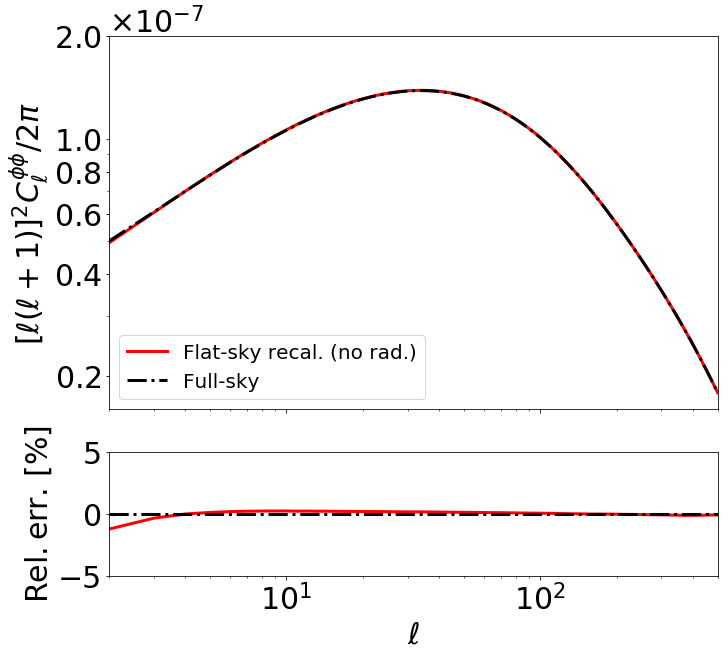

In [14]:
import matplotlib.ticker as ticker
plt.rc('font',size=30)
fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True, constrained_layout= True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.01})
ax0,ax1 = axes[0],axes[1]


ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_wo_rad/(2*np.pi), color = 'r', linewidth = 3 ,label=r'Flat-sky recal. (no rad.)')
ax0.plot(our_l, (our_l*(our_l+1))**2*Clpp/(2*np.pi),'-.', color = 'k',linewidth = 3 , label=r'Full-sky')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend(prop={'size':20})
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=30)
ax0.tick_params(labelsize=30)
ax0.set_yticks(ticks = np.array([2e-8, 4e-8, 6e-8, 8e-8, 1e-7, 2e-7]))
#ax0.set_yticklabels(np.array([r'$\mathrm{2\times10^{-8}}$', r'$\mathrm{4\times10^{-8}}$',r'$\mathrm{6\times10^{-8}}$', r'$\mathrm{8\times10^{-8}}$',r'$\mathrm{1\times10^{-7}}$', \
    #r'$\mathrm{2\times10^{-7}}$']))
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-8,-7)) 
ax0.yaxis.set_major_formatter(formatter)

#ax0.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=15))
plt.setp(ax0.get_xticklabels(), visible=False)

ax1.plot(our_l, (Cl_CMBlensing_wo_rad/Clpp-1)*100,linewidth = 3 , color='r')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.',linewidth = 3 , color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-5, 5)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_xlabel(r'$\ell$',fontsize=30)
ax1.set_ylabel(r'$\rm Rel. err.\,[\%]$',fontsize=30)

In [14]:
def plot_compare_RSD(Cl_full, Cl_limber, our_l, our_Cl, our_Cl_mod, ymin, ymax, xmin, xmax, rescale, title):


    #l_limber = np.load(path_Limber)[0,:]
    #Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,9), sharex=True,constrained_layout= True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
   
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r', linewidth = 3 ,label=r'Flat-sky')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g', linewidth = 3 ,label=r'Flat-sky recal.')
    ax0.plot(our_l, np.abs(Cl_limber)*rescale, '--', color = 'b', linewidth = 3, label=r'Limber recal.')
    ax0.plot(our_l, np.abs(np.array(Cl_full))*rescale,'-.', color = 'k', linewidth = 3 ,label=r'Full-sky')
    
    ax0.set_title(title, fontsize=30)
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend(prop={'size':20})
    ax0.set_ylabel(r'$|C_{\ell}^{\mathrm{RSD}}|\ (\times 10^{%d})$'%np.log10(rescale), fontsize=30)
    #ax0.set_ylabel(r'$C_{\ell}^{\mathrm{RSD}}\ (\times 10^{%d})$'%np.log10(rescale), fontsize=30)
    ax0.tick_params(labelsize=30)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(our_l, (our_Cl/Cl_full-1)*100, color='r', linewidth = 3)
    ax1.plot(our_l, (Cl_limber/np.array(Cl_full)-1)*100,'--', color='b', linewidth = 3)
    ax1.plot(our_l, (our_Cl_mod/Cl_full-1)*100, color='g', linewidth = 3)
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k', linewidth = 3)
    
    ax1.set_xscale('log')
    ax1.set_ylim(-5,5)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=30)
    ax1.set_xlabel(r'$\ell$',fontsize=30)
    ax1.set_ylabel(r'Rel. err. [%]',fontsize=30)

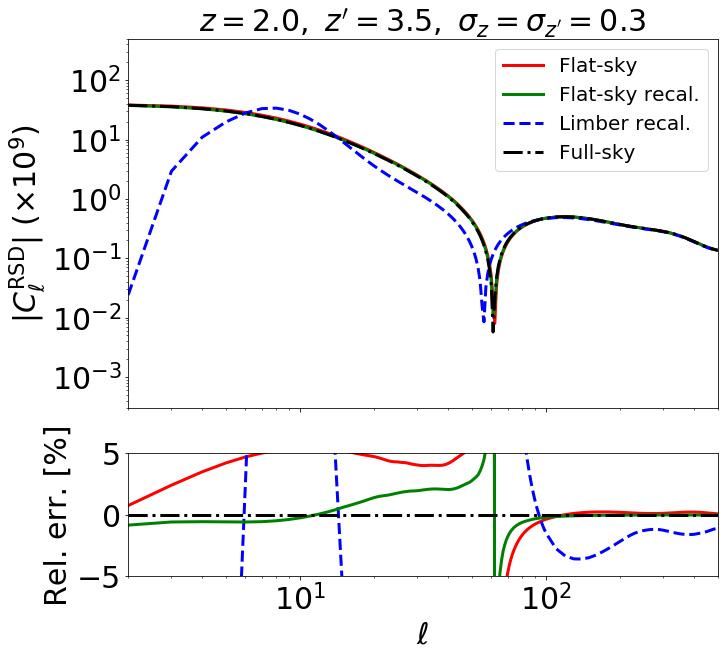

In [16]:
C235_compact = np.load('./Full-Sky/Cl_235_part_Class.npy')
Cl235_full_RSD = C235_compact[:,1]
plot_compare_RSD(Cl235_full_RSD, C235_limber_intpart_new, our_l, Cl235_RSD_our, Cl235_RSD_our_mod, 0.0003, 500, 2, 500, 1e9,r"$z=2.0,\ z'=3.5,\ \sigma_z=\sigma_{z'}=0.3$")